In [99]:
## used for folders/files searching and path finding
import glob
import os

## sound preparation, feature extraction, preprocessing
import librosa
import librosa.display as disp
import soundfile as sf

## math and charts
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import math

## some time measurement
import time

## data read/write with hdf5 files
import h5py

## random lmao
from random import shuffle

TODO:

RCNN
DELETE SOME CODE
ADD VISUALIZATION METHODS

In [2]:
#hop 10ms, window 40
## OUTDATED, LOOK APPENDTRACKS FOR ITS REPLACEMENT
## TO BE DELETED
def appendSounds(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    iterator = 0
    while iterator+16<=mel.shape[1]:
        data.append(mel[:,iterator:iterator+16].flatten())
        labels.append(classNumber)
        iterator+=16

In [100]:
#hop 10ms, window 40
def appendTracks(data,labels,paths,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=506,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64),ref_power= np.max)
    data.append(mel)
    labels.append(classNumber)
    paths.append(fp)

In [122]:
from multiprocessing import Process, Lock, Pipe,Event

## DO NOT USE IF HDF5 FILE HAS BEEN ALREADY CREATED!!!

## whole thing is init method which preprocesses data and puts it into hdf5 file
## only mel scaled spectrograms and classes of sound clips are preserved


data = []

## per process method, extracts data from given fold and sends it to main process
def add(x,c):
    tempdata,templabels,tempPaths = [],[],[]
    for file in glob.glob(x):
        appendTracks(tempdata, templabels, tempPaths, file)
            
    c.send(zip(tempdata, templabels,tempPaths))
    del tempdata,templabels,tempPaths
        

ts = time.time()

if __name__ == '__main__':
    threads= []
    connections=[0]*10
    
    
    ## create threads, assign them methods and start 
    for x in xrange(1,11):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    
    ## wait for threads to finish, get data
    for x,y in zip(threads,connections):
        tD, tL, tP = zip(*y.recv())
        data.append((tD,tL,tP))


    
## create hdf5 file and fill it with data
## format is wholeTracks/fold[NUMBER]/[trackID] and keeps info about spectrogram, as well as class number
## in attributes of dataset

with h5py.File("wholeTracks.hdf5") as f:
    fold = 1
    
    for x in data:
            
        tracks, cls, paths = (x)
        for track, cl, path in zip(tracks,cls,paths):
                
            dset = f.create_dataset(path,data=track)
            dset.attrs['class']=cl       

    f.close()
    
print "I'm done, time was:" , time.time()-ts

##del data

I'm done, time was: 354.149261951


In [140]:
# splits data to train and test arrays, optional tune.
# arrays are given in form of trainData, trainLabels...
# method shall be fed with step between windows (equivalent to their width) and lists of folds that shall create 
# train, (tune), test arrays

# train and tune arrays split tracks into windows of widht = spltStep, test array preserves whole track

def split (splitStep, *data):
    
    with h5py.File("wholeTracks.hdf5") as f:
        
        #no tune set
        if len(data) == 2:
            trainData, trainLabels, testData, testLabels = [],[],[],[]
            
            #create train arrays
            for fold in data[0]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    
                    iterator = 0
                    while iterator + splitStep <= tempTrack.shape[1]:
                        trainData.append(tempTrack[: ,iterator : iterator + splitStep])
                        trainLabels.append(classNumber)
                        iterator += splitStep
            
            #create test arrays         
            for fold in data[1]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    testData.append(grp[track][()])
                    testLabels.append(grp[track].attrs['class'])
                    
            return trainData, trainLabels, testData, testLabels
                 
        # with tune set
        elif len(data) == 3:
            trainData, trainLabels, tuneData, tuneLabels, testData, testLabels = [],[],[],[],[],[]
            
            # create train arrays
            for fold in data[0]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    
                    iterator = 0
                    while iterator + splitStep <= tempTrack.shape[1]:
                        trainData.append(tempTrack[: ,iterator : iterator + splitStep])
                        trainLabels.append(classNumber)
                        iterator += splitStep
                        
            # create tune arrays
            for fold in data[1]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    
                    iterator = 0
                    while iterator + splitStep <= tempTrack.shape[1]:
                        tuneData.append(tempTrack[: ,iterator : iterator + splitStep])
                        tuneLabels.append(classNumber)
                        iterator += splitStep
            
            # create test arrays
            for fold in data[2]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    testData.append(grp[track][()])
                    testLabels.append(grp[track].attrs['class'])
            
            return trainData, trainLabels, tuneData, tuneLabels, testData, testLabels

        else:
            raise NameError("Wrong number of inputs")

In [136]:
## predicts classes on whole database or specified fold from database
def predictOnDataBase(model, splitStep, *data):
    with h5py.File("wholeTracks.hdf5") as f:
        ## prepare list of folds to work on
        if len(data) == 0:
            grps = []
            for grp in f:
                grps.append(f[grp])
        else:
            if type(data[0]) is list:
                for fold in data[0]:
                    grps.append(f['fold' + str(fold)])
            else:
                for fold in data:
                    grps.append(f['fold' + str(fold)])
        
        ## assign scores to every file in fold        
        for grp in grps:
            for clip in grp.keys():
                clip = grp[clip]
                if 'predictions' in clip.attrs:
                    del clip.attrs['predictions']
                
                temp = clip[()]
                trackToPredict = []
                iterator = 0
                    
                ## if clip is too short to predict even 1 window, expand it
                if temp.shape[1]<16:
                    t = temp.shape[1]
                    b = np.zeros((64,16))
                    b[:, :-16+t]= temp
                    trackToPredict.append(b)
                else:
                    ## iterate through clip and split it into windows
                    while iterator + splitStep <= temp.shape[1]:
                        trackToPredict.append(temp[: ,iterator : iterator + splitStep])
                        iterator += splitStep
                    
                ## prepare clip as a corrent CNN input and predict probabilities
                trackToPredict= np.array(trackToPredict)
                trackToPredict = np.expand_dims(trackToPredict, axis=3)
                predicted = model.predict(trackToPredict, batch_size=1, verbose=2)

                ## predicted is a matrix of probabilities, where each row has 10 probabilities of being
                ## specific class, each row represents one predicted window
                
                ## to predictions append list of best prediction of class for each window
                ## predicted is majority vote over all windows (but voted using probabilities, not classes)
                clip.attrs['predictions']=np.argmax(predicted,axis=1)
                clip.attrs['predicted']=predicted.sum(axis=0).argmax()
        
            

In [137]:
## prints score and accuracy matrix for whole dataset or for given folds
def getScores(*data):
    scores = np.zeros((10,10))
    with h5py.File("wholeTracks.hdf5") as f:
        grps = []
        ## prepare folds to print scores for
        if not data:
            for grp in f:
                grps.append(f[grp])
        else:
            if type(data[0]) is list:
                for fold in data[0]:
                    grps.append(f['fold' + str(fold)])
            else:
                for fold in data:
                    grps.append(f['fold' + str(fold)])

        for grp in grps:
            for clip in grp.keys():
                clip = grp[clip]

                scores[clip.attrs['predicted'],clip.attrs['class']] += 1
                
                
            
    ## returns confusion matrix (where rows are predicted classes and columns are actuall classes)
    ## as well as accuracy 
    return scores, scores.trace()/scores.sum()
                    
        

In [189]:
## look for clips searching for class or/and prediction
def findClips( actual = None, predicted = None, folds = None):
    if actual == None and predicted == None:
        print "Specify actual or predicted classes to search for"
        return None
    if actual != None:
        if type(actual) is not list:
            temp = actual
            actual = []
            actual.append(temp)
        actual = set(actual)
    if predicted != None:
        if type(predicted) is not list:
            temp = predicted
            predicted = []
            predicted.append(temp)
        predicted = set(predicted)
        
    
    
    toReturn =[]
    grps =[]
    
    with h5py.File("wholeTracks.hdf5") as f:
        if folds == None:
            for grp in f:
                grps.append(f[grp])
        else:
            for fold in folds:
                grps.append('fold' + str(fold))
                    
        if actual and predicted:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['class'] in actual and clip.attrs['predicted'] in predicted:
                        toReturn.append(clip.name)
                    
        elif actual:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['class'] in actual:
                        toReturn.append(clip.name)
                        
        elif predicted:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['predicted'] in predicted:
                        toReturn.append(clip.name)
    
    return toReturn

                

In [167]:
## show spectrogram of given file
def showClip(fPath):
    with h5py.File("wholeTracks.hdf5") as f:
        clip = f[fPath]
        print fPath
        disp.specshow(clip[()])
        plt.show()

In [ ]:
## OUTDATED - REPLACED BY HDF5
## KEPT JUST IN CASE, TO BE DELETED

from multiprocessing import Process, Lock, Pipe,Event
import time
from keras import utils


allData,allLabels=[],[]
trainData,trainLabels= [],[]
tuneData,tuneLabels=[],[]
testData,testLabels=[],[]
#function to extract data using multiprocessing
def add(x,c):
    tempdata,templabels = [],[]
    if int(x[4])<9:
        try:
            int(x[5])
        except:
            #split for training set - loses information about which clip batch comes from 
            for file in glob.glob(x):
                appendSounds(tempdata, templabels, file)
        else:
            #split for testing set - presumes batches of sound within clip
            for file in glob.glob(x):
                appendTracks(tempdata, templabels, file)
        
        
    else:
        #split for testing set - presumes batches of sound within clip
        for file in glob.glob(x):
            appendTracks(tempdata, templabels, file)
            
    c.send(zip(tempdata, templabels))
    del tempdata,templabels
        
ts = time.time()

#doing actual multiprocessing extraction
if __name__ == '__main__':
    threads= []
    connections=[0]*10
    lock = Lock()
    for x in xrange(1,11):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    fold = 1
    for x,y in zip(threads,connections):
        tD, tL = zip(*y.recv())
        if fold <= 6:
            trainData += tD
            trainLabels += tL
        elif fold <= 8 :
            tuneData += tD
            tuneLabels += tL
        else:
            testData += tD
            testLabels += tL
        fold+=1
        
    #save data into numpy array, change classes label using onehot encoding
    trainData, trainLabels = np.array(trainData), np.array(utils.to_categorical(trainLabels, num_classes=10))
    tuneData, tuneLabels = np.array(tuneData), np.array(utils.to_categorical(tuneLabels, num_classes=10))
    #testData, testLabels = np.array(testData), np.array(utils.to_categorical(testLabels, num_classes=10))
    
    print "I'm done, time was:" , time.time()-ts

In [50]:
## NO PROPER DATA PREPARATION FOR THIS PART RIGHT NOW, GIVES POOR SCORES ANYWAY
## PROCEED TO CNN PART


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers
from random import uniform
from math import pow
rates2 = []

#standard NN - was fine tuned for another example, outdated right now

LR,L2= 0.008,0.00207
net = Sequential()
net.add(Dense(512, activation='relu', input_dim=1024,
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.5))
net.add(Dense(256, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.3))
net.add(Dense(64, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.1))
net.add(Dense(10, activation='softmax'))
net.compile(loss='categorical_crossentropy',
           optimizer = SGD(lr=LR,decay=1e-6, momentum=0.9,nesterov=True),
           metrics = ['accuracy'])

net.fit(trainData, trainLabels, epochs = 100, batch_size=128, verbose=0)
rates2.append([net.evaluate(tuneData,tuneLabels, batch_size=16384)[1],
             net.evaluate(trainData,trainLabels, batch_size=16384)[1],
             LR,L2])
print ("Tune score: %.3f Train score: %.3f Learning rate: %f L2 reg: %f" %(rates2[-1][0],rates2[-1][1],LR, L2))

23987/23987 [==============================] - 0s     
Tune score: 0.294 Train score: 0.351 Learning rate: 0.008000 L2 reg: 0.002070


In [163]:
## prepare data for CNN training

## split folds into train, tune and test sets
trainData, trainLabels, tuneData, tuneLabels, testData, testLabels = split(16, [1,2,3,4,5,6,7],[8],[9,10])

## lists to np arrays
trainData=np.array(trainData)
trainLabels=np.array(trainLabels)
tuneData=np.array(tuneData)
tuneLabels=np.array(tuneLabels)


## add 3rd dim - channel required by conv layers
trainData=np.expand_dims(trainData,axis=3)
tuneData=np.expand_dims(tuneData,axis=3)

from keras import utils

## classes to vector - one hot encode
trainLabels = np.array(utils.to_categorical(trainLabels, num_classes=10))
tuneLabels = np.array(utils.to_categorical(tuneLabels, num_classes=10))

In [164]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD

#CNN working on batches of image, accuracy up to 72%

model = Sequential()
model.add(ZeroPadding2D(padding = (1,1), input_shape=(64, 16, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

model.fit(trainData, trainLabels, batch_size=512, epochs=100,verbose=0)
predictOnDataBase(model,16)

0.686864579097
[[ 126.    0.    2.   10.    2.   15.    1.    8.    3.    0.]
 [   0.   66.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  20.    4.  234.   28.    6.    9.    0.    3.   17.   22.]
 [   1.    0.   25.  223.   17.    1.   21.    0.   16.    6.]
 [  50.    1.    4.    7.  199.    0.    1.   85.   37.    2.]
 [   7.    0.    6.    9.    1.  193.    0.    3.    3.    0.]
 [   0.    0.    2.    0.    4.    0.   69.    1.    0.    0.]
 [  42.   13.    5.    7.   50.   35.    0.  155.    2.    1.]
 [   5.    0.    7.    8.    2.    0.    1.    1.  163.    8.]
 [  49.   11.   15.    8.   19.   17.    0.    0.    4.  261.]]
[ 42.  69.  78.  74.  66.  71.  74.  61.  67.  87.]


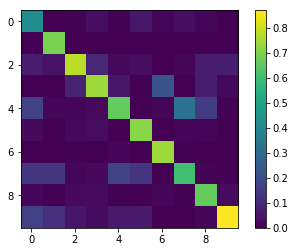

In [198]:
## print scores and graphic version
## confusion matrix, x - actual class, y - predicted class
from sklearn.preprocessing import normalize
scores = getScores(8,9,10)
print scores[1]
print scores[0]
np.set_printoptions(precision=0)
print 100*np.diag(scores[0])/scores[0].sum(axis=0)
normscores =normalize(scores[0],norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()
plt.show()


/fold8/4918-3-0-0.wav


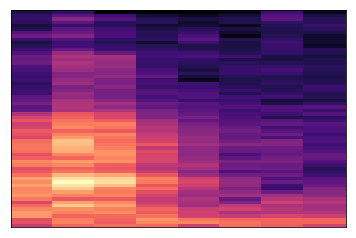

/fold8/89207-3-0-0.wav


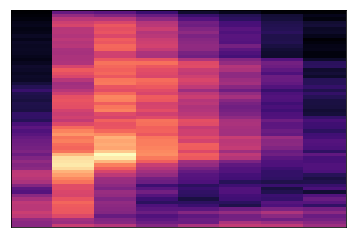

/fold9/52740-3-0-0.wav


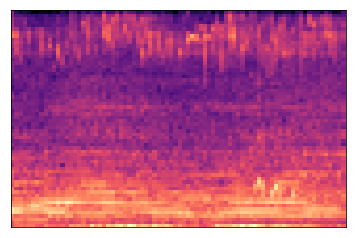

/fold9/52740-3-0-1.wav


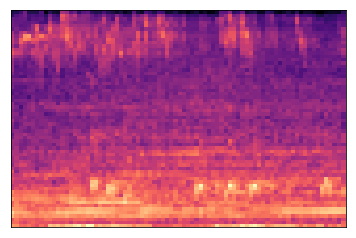

/fold9/79584-3-1-2.wav


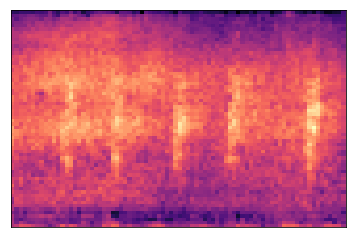

/fold10/102103-3-1-0.wav


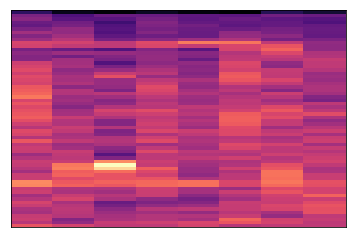

/fold10/142641-3-0-0.wav


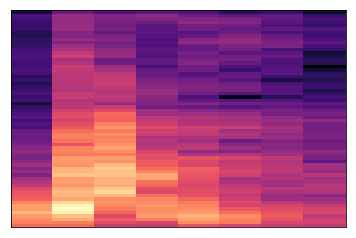

In [191]:
for x in findClips(actual=3, predicted =4, folds= [8,9,10]):
    showClip(x)

In [6]:
## AS WELL OUTDATED, SCORES ARE NOW BASED ON PREDICTIONS SAVED IN HDF5 FILE

#final scoring function. isnt used in training.
#CNN predicts classes for all parts of clip and sums probablities, chooses best
#scores is confusion matrix
scores = np.zeros((10,10))
for track,label in zip(testData,testLabels):
    tempD =[]
    iterator = 0
    ## if track is too short for even one window to predict, fill it up with zeros to one window size
    if track.shape[1]<16:
        t = track.shape[1]
        b = np.zeros((64,16))
        b[:, :-16+t]= track
        tempD.append(b)
    while (iterator+16<=track.shape[1]):
        tempD.append(track[:,iterator:iterator+16])
        iterator+=16
    tempD= np.array(tempD)
    tempD = np.expand_dims(tempD, axis=3)
    predicted = model.predict(tempD, batch_size=1, verbose=2)
    scores[predicted.sum(axis=0).argmax(),label]+=1

accuracy = scores.trace()/scores.sum()    
print accuracy

0.67332123412


[[ 109.    0.    0.    4.    3.   27.    1.   25.    0.    0.]
 [   3.   63.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  93.    6.  274.   46.   28.   55.    1.   28.   32.   55.]
 [  13.    4.   17.  224.   19.    2.   26.    2.   10.    7.]
 [  19.    1.    1.    5.  196.    0.    1.   67.   10.    0.]
 [   1.    1.    1.    1.    2.  151.    0.    5.    2.    1.]
 [  11.    1.    1.    0.    1.    0.   64.    0.    0.    1.]
 [   6.   12.    1.    3.   32.   17.    0.  126.    0.    0.]
 [  25.    0.    3.    9.    8.    5.    0.    1.  190.    8.]
 [  20.    7.    2.    8.   11.   13.    0.    2.    1.  228.]]


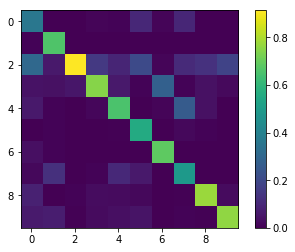

In [99]:
from sklearn.preprocessing import normalize

## print scores and graphic version
## confusion matrix, x - actual class, y - predicted class
scores = getScores(8,9,10)[0]
print scores
normscores =normalize(scores,norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()
plt.show()

Some charts used in finetuning of previous NN

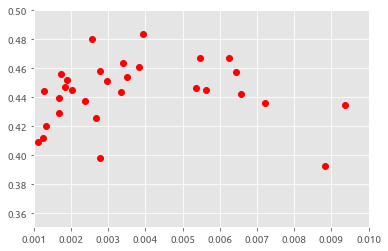

In [43]:
plt.plot(rates[:,2],rates[:,0],'ro')
plt.axis([0.001,0.01,0.35,0.5])
plt.show()
#128 batch - f(learning_Rate)=score

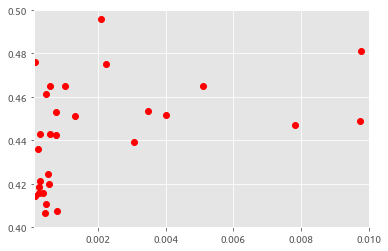

In [50]:
plt.plot(rates1[:,3],rates1[:,0],'ro')
plt.axis([0.0001,0.01,0.4,0.5])
plt.show()
#128 batch - f(L2 lambda)=score, lr=0.0038